In [3]:
!pip install h5py
!pip install h5py_cache

In [15]:
path_peer = r'/home/sasha/Документы/Кодъ'

In [16]:
import os

os.chdir(path_peer)
print('Directory is set to', os.getcwd())

Directory is set to /home/sasha/Документы/Кодъ


In [17]:
# реформатирование аудио
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# путь до файлов препроцессинга
DATA_FOLDER = r'/home/sasha/Документы/Кодъ/data'

# Слайсинг входных данных.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Длина фрейма для лейбла.
FRAME_SIZE_MS = 10

# Слайсы по размеру фрейма.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))


In [18]:
import torch

OBJ_CUDA = torch.cuda.is_available()

OBJ_PREPARE_AUDIO = True
OBJ_TRAIN_MODELS = True

if OBJ_CUDA:
    print('CUDA has been enabled.')
else:
    print('CUDA has been disabled.')

CUDA has been enabled.


In [14]:
'''from pydub import AudioSegment
import os

def equalize_volume(folder_path, target_dBFS):
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            sound = AudioSegment.from_wav(file_path)
            
            # Calculate the current dBFS level
            current_dBFS = sound.dBFS
            
            # Calculate the difference in dBFS to reach the target level
            dBFS_difference = target_dBFS - current_dBFS
            
            # Apply the volume adjustment
            normalized_sound = sound + dBFS_difference
            
            # Export the adjusted audio
            normalized_sound.export(file_path, format="wav")

folder1_path = "/home/sasha/Документы/Кодъ/NoiseFiles"
folder2_path = "/home/sasha/Документы/Кодъ/SpeechFiles"
target_dBFS = -25  # Adjust this value as needed

equalize_volume(folder1_path, target_dBFS)
equalize_volume(folder2_path, target_dBFS)'''


In [5]:
import os

# Папка, содержащая ваши файлы
folder_path = '/home/sasha/Документы/Кодъ/NoiseData/TMETRO_16k/TMETRO'

# Получаем список файлов в папке
files = os.listdir(folder_path)

# Префикс, который вы хотите добавить к именам файлов
prefix = 'metro'

# Счетчик для добавления уникальных номеров к именам файлов
counter = 1

# Перебираем файлы и переименовываем их
for file in files:
    # Формируем новое имя файла
    new_name = f"{prefix}{counter}.wav"
    # Полный путь к текущему файлу
    old_path = os.path.join(folder_path, file)
    # Полный путь к новому файлу
    new_path = os.path.join(folder_path, new_name)
    # Переименовываем файл
    os.rename(old_path, new_path)
    # Увеличиваем счетчик
    counter += 1

print("Файлы успешно переименованы.")

FileNotFoundError: [Errno 2] No such file or directory: '/home/sasha/Документы/Кодъ/NoiseData/TMETRO_16k/TMETRO'

Directory is set to /home/sasha/Документы/Кодъ
Found 173 tracks to check.
Processing 173 of 173
Done!
Found 930 tracks to check.
Processing 930 of 930
Done!
Frame merging already done. Skipping.
Frame merging already done. Skipping.
Frame labelling already done. Skipping.


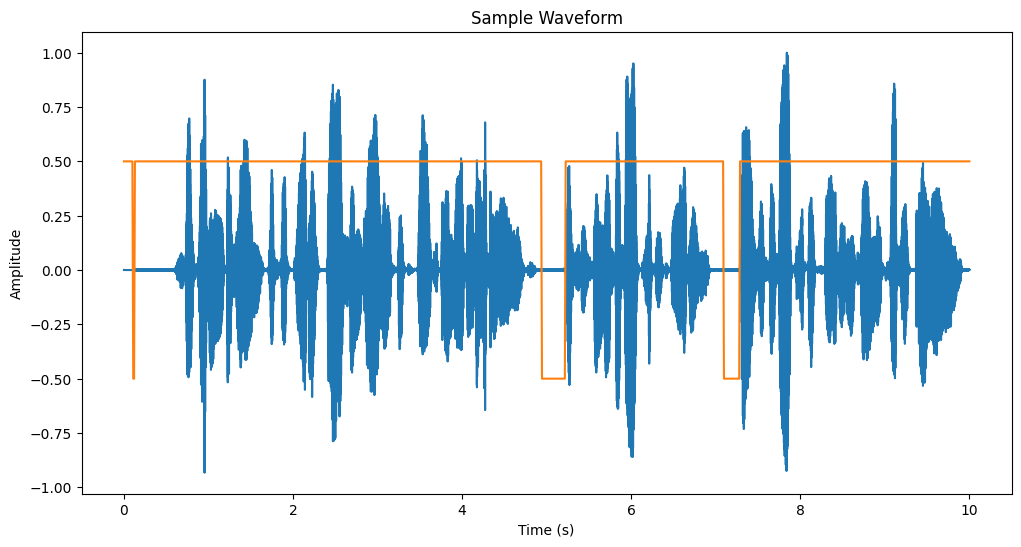

In [56]:
import h5py
import numpy as np
import math
import python_speech_features
import glob
from pydub import AudioSegment
import webrtcvad
import os
import matplotlib.pyplot as plt

# FileManager Class
class FileManager:
    def __init__(self, name, directory):
        self.name = name
        self.data = h5py.File(DATA_FOLDER + '/' + name + '.hdf5', 'a')

        if 'files' not in self.data:
            files = glob.glob(directory + '/**/*.wav', recursive=True)
            files.extend(glob.glob(directory + '/**/*.flac', recursive=True))
            files = [f for f in files]

            dt = h5py.special_dtype(vlen=str)
            self.data.create_dataset('files', (len(files),), dtype=dt)

            for i, f in enumerate(files):
                self.data['files'][i] = f

    def get_track_count(self):
        return len(self.data['files'])

    def prepare_files(self, normalize=False):
        if not OBJ_PREPARE_AUDIO:
            print(f'Skipping check for {self.name}.')
            return

        print('Found {0} tracks to check.'.format(self.get_track_count()))
        progress = 1

        if 'raw' not in self.data:
            dt = h5py.special_dtype(vlen=np.dtype(np.int16))
            self.data.create_dataset('raw', (self.get_track_count(),), dtype=dt)

        for i, file in enumerate(self.data['files']):
            print('Processing {0} of {1}'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

            if len(self.data['raw'][i]) > 0:
                continue

            track = (AudioSegment.from_file(file.decode("utf-8"))
                     .set_frame_rate(SAMPLE_RATE)
                     .set_sample_width(SAMPLE_WIDTH)
                     .set_channels(SAMPLE_CHANNELS))

            if normalize:
                track = track.apply_gain(-track.max_dBFS)

            self.data['raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)

        self.data.flush()
        print('\nDone!')

    def collect_frames(self):
        if 'frames' in self.data:
            print('Frame merging already done. Skipping.')
            return

        if 'raw' not in self.data:
            print('Could not find raw data!')
            return

        frame_count = 0
        progress = 1

        for raw in self.data['raw']:
            frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
            print('Counting frames ({0} of {1})'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

        dt = np.dtype(np.int16)
        self.data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)

        progress = 0
        buffer = np.array([])
        buffer_limit = FRAME_SIZE * 4096

        for raw in self.data['raw']:
            raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))
            buffer = np.concatenate((buffer, raw))

            if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
                continue

            frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
            buffer = np.array([])

            self.data['frames'][progress: progress + len(frames)] = frames

            progress += len(frames)
            print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)

        self.data.flush()
        print('\nDone!')

    def label_frames(self):
        if 'labels' in self.data:
            print('Frame labelling already done. Skipping.')
            return

        if 'frames' not in self.data:
            print('Could not find any frames!')
            return

        vad = webrtcvad.Vad(0)
        frame_count = len(self.data['frames'])
        progress = 0
        batch_size = 65536

        dt = np.dtype(np.uint8)
        self.data.create_dataset('labels', (frame_count,), dtype=dt)

        for pos in range(0, frame_count, batch_size):
            frames = self.data['frames'][pos: pos + batch_size]
            labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
            self.data['labels'][pos: pos + batch_size] = np.array(labels)

            progress += len(labels)
            print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)

        self.data.flush()
        print('\nDone!')

    def plot_sample(self, index_from, index_to):
        frames = self.data['frames'][index_from: index_to]
        labels = self.data['labels'][index_from: index_to]
        self._plot_waveform(frames, labels)

    def _plot_waveform(self, frames, labels):
        raw = self._norm_raw(frames.flatten())
        time = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(raw))
        time_labels = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(labels))

        plt.figure(figsize=(12, 6))
        plt.plot(time, raw)
        plt.plot(time_labels, labels - 0.5)
        plt.title('Sample Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

    def _norm_raw(self, raw):
        return raw / np.max(np.abs(raw), axis=0)

# Constants
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000
FRAME_SIZE_MS = 10
FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))
OBJ_PREPARE_AUDIO = True

# Setting up directories
path_peer = r'/home/sasha/Документы/Кодъ'
DATA_FOLDER = r'/home/sasha/Документы/Кодъ/data'
os.chdir(path_peer)
print('Directory is set to', os.getcwd())

# Test
speech_dataset = FileManager('speech', r'/home/sasha/Документы/Кодъ/SpeechFiles')
noise_dataset = FileManager('noise', r'/home/sasha/Документы/Кодъ/NoiseFiles')
speech_dataset.prepare_files()
noise_dataset.prepare_files(normalize=True)
speech_dataset.collect_frames()
noise_dataset.collect_frames()
speech_dataset.label_frames()

# Plotting sample waveform
speech_dataset.plot_sample(0, 1000)  # Change the range as needed


In [57]:
# Test
generator = DataGenerator(data, size_limit=10000)
generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-15')
generator.use_train_data()
X, y = generator.get_batch(0)
print(f'Load a few frames into memory:\n{X[0]}\n\nCorresponding label: {y[0]}')


Load a few frames into memory:
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -3.4321694e-14  0.0000000e+00  0.0000000e+00
   0.0000000e+00  9.6402870e-15  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -3.4321694e-14  0.0000000e+00  0.0000000e+00
   0.0000000e+00  9.6402870e-15  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -3.4321694e-14  0.0000000e+00  0.0000000e+00
   0.0000000e+00  9.6402870e-15  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.00

In [24]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


ЭТО НАХУЙ EFFICIENTNET

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EfficientNetSingle(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, padding, dilation, dropout):
        super(EfficientNetSingle, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=padding, 
                      dilation=dilation, bias=False),
            nn.BatchNorm1d(output_size),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        out = self.layer(x)
        return torch.cat([x, out], 1)

class EfficientNetBlock(nn.Module):
    def __init__(self, input_size, n_layers, growth_rate, kernel_size, padding, dilation, dropout):
        super(EfficientNetBlock, self).__init__()
        layers = []
        for i in range(n_layers):
            layers.append(EfficientNetSingle(input_size + i * growth_rate, growth_rate, 
                                      kernel_size, padding, dilation, dropout))
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):        
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(TransitionBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(output_size),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        return self.layers(x)
    
class EfficientNet(nn.Module):
    def __init__(self, large=False):
        super(EfficientNet, self).__init__()
        if large:
            dropout = 0.4
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=48, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(48),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.block1 = EfficientNetBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, dropout=dropout)
            self.trans1 = TransitionBlock(input_size=80, output_size=48, dropout=dropout)
            self.block2 = EfficientNetBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, dropout=dropout)
            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=80, out_channels=80, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(80),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.out = nn.Linear(80, 2, bias=False)
        else:
            dropout = 0.4
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=24, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(24),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.block1 = EfficientNetBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, dropout=dropout)
            self.trans1 = TransitionBlock(input_size=42, output_size=24, dropout=dropout)
            self.block2 = EfficientNetBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, dropout=dropout)
            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=42, out_channels=42, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(42),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.out = nn.Linear(42, 2, bias=False)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn_in(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.cnn_out(x)
        x = x.mean(dim=-1)  # Global average pooling
        return F.softmax(self.out(x), dim=1)

# Example usage
BATCH_SIZE = 2048
effnet = EfficientNet(large=True)
print(effnet)


EfficientNet(
  (cnn_in): Sequential(
    (0): Conv1d(24, 48, kernel_size=(6,), stride=(1,), dilation=(4,), bias=False)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
  )
  (block1): EfficientNetBlock(
    (block): Sequential(
      (0): EfficientNetSingle(
        (layer): Sequential(
          (0): Conv1d(48, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.4, inplace=False)
        )
      )
      (1): EfficientNetSingle(
        (layer): Sequential(
          (0): Conv1d(52, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
     

In [51]:
BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6
MAX_EPOCHS = 15



In [52]:
import torch
import torch.nn.functional as F

generator = DataGenerator(data)
generator.setup_generation(frame_count=FRAMES, step_size=STEP_SIZE, batch_size=BATCH_SIZE)
generator.use_train_data()
generator.set_noise_level_db('None')

print(generator.batch_count, 'training batches were found.')

def accuracy(out, y):
    # Get the index of the maximum value along the second dimension (argmax)
    out = torch.max(out, 1)[1].float()
    # Check equality element-wise and convert to float
    eq = torch.eq(out, y.float()).float()
    # Calculate mean of the equalities
    return torch.mean(eq)

temp, OBJ_CUDA = OBJ_CUDA, False
effnet, OBJ_CUDA = EfficientNet(large=True), temp
del temp

for i in range(3):
    
    X, y = generator.get_batch(i)
    X = torch.from_numpy(np.array(X)).float().cpu()
    y = torch.from_numpy(np.array(y)).cpu()

    out = effnet(X)
    acc = accuracy(out, y).item()  # Use .item() to get Python float instead of numpy float

print('Successfully ran the network!\n\nExample output:', out.data.numpy()[0])


955 training batches were found.
Successfully ran the network!

Example output: [0.43880597 0.56119406]


ТУТ СУКА ПРОБЛЕМА


In [31]:
import torch.optim as optim
from IPython.display import clear_output
import time
from torch.autograd import Variable
import os
import torch.nn as nn
import numpy as np

NOISE_LEVELS = ['None', '-15', '-3']

def net_path(epoch, title):
    part = os.path.join(os.getcwd(), 'models', title)
    if epoch >= 0:
        return part + '_epoch' + str(epoch).zfill(3) + '.net'
    else:
        return part + '.net'

def save_net(model, epoch, title):
    if not os.path.exists(os.getcwd() + '/models'):
        os.makedirs(os.getcwd() + '/models')
    torch.save(model.state_dict(), net_path(epoch, title))
    
def load_net(epoch = MAX_EPOCHS-1, title = 'cGRU'):
    if OBJ_CUDA:
        return torch.load(net_path(epoch, title))
    else:
        return torch.load(net_path(epoch, title), map_location='cpu')

def train_net(net, data, size_limit = 0, noise_level = 'None', epochs = MAX_EPOCHS, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True):

    
    # Задаем генератор
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.train_size == 0:
        print('Error: no training data was found!')
        return
    
    if OBJ_CUDA:
        print('cuda ', OBJ_CUDA)
        net.cuda()

    
    criterion = nn.CrossEntropyLoss()
    levels = [noise_level]
    
    if OBJ_CUDA:
        criterion.cuda()
    
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    if verbose:
        print(net)
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size
        _vlsz = generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        print(f'Criterion: Cross-Entropy ({noise_level} dB)')
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Optimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')


    
    net.train()
    stalecount, maxacc = 0, 0
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Строит обновляемые графики лоссов и метрик (если verbose)
        '''
        clear_output(wait=True)
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        
        
    def run(net, optimize = False):
        '''
        Прогон одной эпохи. Фреймы закидываются генераторами по мере необходимости,
        не тратя память. Возвращает средний лосс и accuracy
        '''
        epoch_loss, epoch_acc, level_acc = 0, [], []
        
        #Если мы используем фокал лосс, то нужны все уровни шума
        batches = generator.batch_count
        print('batches in run ', batches)
        num_batches = batches*len(levels)
        print('num_batches in run ', num_batches)
        
        if num_batches == 0:
            raise ValueError('Not enough data to create a full batch!')
        
        # Хелпер для прогона батча
        def run_batch(X, y, epoch_loss, epoch_acc):

            X = Variable(torch.from_numpy(np.array(X)).float())
            y = Variable(torch.from_numpy(np.array(y))).long()

            if OBJ_CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)
#             print('net_out in run_batch', out.shape)

            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # В тренировке считаем бэкпроп и оптимизатор
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if OBJ_CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc
        
        # для всех заданных уровней шума
        for lvl in levels:
            
            # подстраиваем генератор под уровень шума
            generator.set_noise_level_db(lvl)
            
            for i in range(batches):

                X, y = generator.get_batch(i)
#                 print('get_batch_train/val ', np.array(X).shape, np.array(y).shape)
                temp_loss, temp_acc = run_batch(X, y, epoch_loss, epoch_acc)
                epoch_loss += temp_loss / float(num_batches)
                level_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(level_acc)
    
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    # итерируемся по всем эпохам
    for epoch in range(epochs):
        
        # считаем лосс и accuracy для эпохи и оптимизируем по ним
        generator.use_train_data()
        loss, acc = run(net, optimize=True)
        print(loss, loss)
        losses.append(loss)
        accs.append(acc)
        
        # Если генератор валидации не кончился, считаем метрики валидации
        if generator.val_size != 0:
            net.eval()
            generator.use_validate_data()
            val_loss, val_acc = run(net)
            print(val_loss, val_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            net.train()
            
            # Если задан early stop, то чекаем, не застряла ли accuracy валидации, иначе останавливаем
           
            if epoch > 0 and val_accs[-1] <= maxacc:
                stalecount += 1
                if stalecount > patience and early_stopping:
                    return
            else:
                stalecount = 0
                maxacc = val_accs[-1]
        
        if auto_save:
            save_net(net, epoch, title)
        
        # Строим график метрик, если надо
        if verbose:             
            plot(losses, accs, val_losses, val_accs)


In [32]:
def set_seed(seed = 666):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if OBJ_CUDA:
        torch.cuda.manual_seed_all(seed)

In [33]:
from sklearn import metrics

def test_predict(net, data, size_limit, noise_level):
    '''
    Вычисляет предсказания на тесте
    '''
    
    # Датагенератор со стандартными параметрами
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []
#     print('batches in test_predict ', generator.batch_count)

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()
#         print('batches shape in test_predict ', X.shape, y.shape)

        if OBJ_CUDA:
            X = X.cuda()

        out = net(X)
        
#         print('net out in test_predict ', out.shape)

        if OBJ_CUDA:
            out = out.cpu()
            y = y.cpu()

        #ground-truth лейблы
        y_true.extend(y.data.numpy())

        # Насчитанные сеткой вероятностные лейблы
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score
    


def roc_auc(net, data, noise_lvl, size_limit = 0):
    plt.figure(1, figsize=(16, 10))
    plt.title('Receiver Operating Characteristic (%s)' % noise_lvl, fontsize = 16)
    print('roc_auc')
        
    # предсказания
    y_true, y_score = test_predict(net, data, size_limit, noise_lvl)

    # считаем ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc_res = metrics.auc(fpr, tpr)

    # строим 
    plt.plot(fpr, tpr, label='(AUC = %0.3f)' % (auc_res))

#     plt.xlim([0, 0.2])
#     plt.ylim([0.6, 1])
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right', prop={'size': 16})
    plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
import math
import matplotlib.pyplot as plt


def reject_metrics(net, data, size_limit = 0, frr = 1, far = 1, plot = True):
    lvls = {'None': 'no noise', '-15': 'low noise', '-3': 'high noise'}
    '''
    Computes the confusion matrix for a given network.
    '''
    
    # Применяем трешхолды к предиктам
    def apply_threshold(y_score, t = 0.5):
        return [1 if y >= t else 0 for idx, y in enumerate(y_score)]
    
    def fix_frr(y_true, y_score, frr_target, noise_level):
        
        # костыль
        if noise_level == 'None':
            t = 1e-4
        elif noise_level == '-15':
            t = 1e-5
        else:
            t = 1e-9
        
        # фиксированный FR
        while t < 1.0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            
            if frr >= frr_target:
                return far, frr, t
            
            t *= 1.1
    
        # Возвращаем самый похожий результат, если нет совпадений
        return far, frr, t
    
    def fix_far(y_true, y_score, far_target):
        
        t = 1.2
        
        # фиксированный FА
        while t > 0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if far >= far_target:
                return frr, far, t
            
            t *= 0.999
    
        return frr, far, t
    
    def eer(y_true, y_score):
        fpr, tpr, threshold = metrics.roc_curve(y_true, y_score, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        return EER, eer_threshold

    print('Network metrics:')

    # для каждого уровня шума
    for lvl in NOISE_LEVELS:
        
        y_true, y_score = test_predict(net, data, size_limit, lvl)
        ffr = fix_frr(y_true, y_score, frr, lvl)
        ffa = fix_far(y_true, y_score, far)
        fafr = eer(y_true, y_score)
        

        
        print(f'FAR: {ffr[0]}% for fixed FRR at {ffr[1]}% with threshhold {ffr[2]} and ', lvls[lvl])
        print(f'FRR: {ffa[0]}%  for fixed FAR at {ffa[1]}% with threshhold {ffa[2]} and ', lvls[lvl])
        print(f'EER: {fafr[0]*100}% with threshhold {fafr[1]} and ', lvls[lvl])
    



In [35]:
def netvad(net, data, noise_level = '-3', init_pos = 2000, length = 1000, only_plot_net = False):
    '''
    Генерирует сэмпл заданной длинный и прогоняет его через сетку.
    Строит графики оригинального аудио с ground truth лейблом, 
    полученным лейблом, а также лейбл WebRTC для сравнения.
    '''
    
    # инициируем генератор
    generator = DataGenerator(data)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    raw_frames, mfcc, delta, labels = generator.get_data(init_pos, init_pos+length)

    # конвертируем семпл во фреймы
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
        
    # делаем батч из фреймов
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
        
    # предсказываем для каждого фрейма
    offset = 15
    accum_out = [0] * offset
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        

    # паддинг
    if num_frames > 0:
        accum_out = accum_out[:len(accum_out)-(BATCH_SIZE-num_frames)]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)
    
    # обрезаем по границам предсказания
    raw_frames = raw_frames[offset:-offset]
    labels = labels[offset:-offset]
    accum_out = accum_out[offset:]

    print('Displaying results for noise level:', noise_level)
    if not only_plot_net:
        Vis.plot_sample(raw_frames, labels, show_distribution = False)
        Vis.plot_sample_webrtc(raw_frames, sensitivity = 0)
    Vis.plot_sample(raw_frames, accum_out, title = 'Sample (Neural Net)', show_distribution = False)



In [36]:
import soundfile as sf
import python_speech_features
import numpy as np
def vad(net, file):
    '''
    Прогоняет через сетку произвольный файл и считает лейбл. 
    '''
    
    audio, _ = sf.read(file)
    mfcc_window_frame_size=4
    
    
    mfcc = python_speech_features.mfcc(audio, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    mfcc = mfcc[:, 1:]
    length = mfcc.shape[0]
    delta = python_speech_features.delta(mfcc, 2)

    # файл во фреймы
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
     # делаем батч из фреймов   
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
    # предсказываем для каждого фрейма

    accum_out = []
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        

    # подгоняем по размеру
    if num_frames > 0:
        accum_out = accum_out[:num_frames+FRAMES]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)  

    Vis.plot_sample(audio, accum_out, title = file, show_distribution = False)
    
    return(file.split('\\')[-1], list(accum_out))



In [37]:
import os
import numpy as np
import wave
import webrtcvad
import collections
import contextlib
import sys
import wave

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):

    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):

    labels = []
    labels = np.array([1 if vad.is_speech(frame.bytes, sample_rate) else 0 for frame in frames])

    return labels
        

def vad_webrtc(file):
    
    audio, sample_rate = read_wave(file)
    _audio, _ = sf.read(file)
    vad = webrtcvad.Vad(0)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    labels = vad_collector(sample_rate, 10, 300, vad, frames)

    Vis.plot_sample(_audio, labels, title = file+' WebRTC', show_distribution = False)
    
    return(file.split('\\')[-1], list(labels))

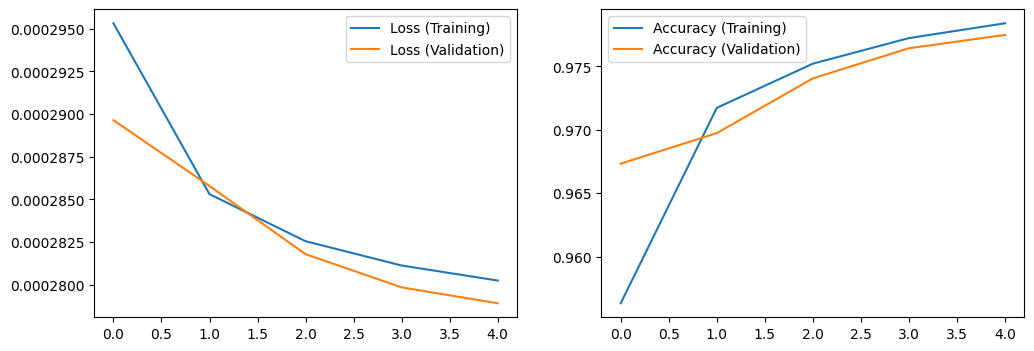

batches in run  955
num_batches in run  955


KeyboardInterrupt: 

In [38]:
OBJ_TRAIN_MODELS = True
if OBJ_TRAIN_MODELS:
    
#     set_seed()
#     gru = cGRU()
#     train_net(gru, data, title='cGRU', gamma=2)
    

    set_seed()
    effnet = EfficientNet(large=True)
    train_net(effnet, data, title='EfficientNet', gamma=2)
    
    
else:
    
#     gru = load_net(title='cGRU')
    effnet = load_net(title='effnet')



print('\nROC Curves:')


roc_auc(effnet, data, 'None')
roc_auc(effnet, data, '-15')
roc_auc(effnet, data, '-3')


print('\nTresholds:')


print('\nEfficientNet:')
reject_metrics(effnet, data, frr=1, far=1)


print('\nQualitative results:')


print('\neffnet:')
netvad(effnet, data, only_plot_net=True)




Предсказания на noisy датасете, где каждый файл обрабатывается по отдельности



Test set evaluation:
1329efc2-139c-4e64-be9b-a026bb3c646e.wav

effnet:


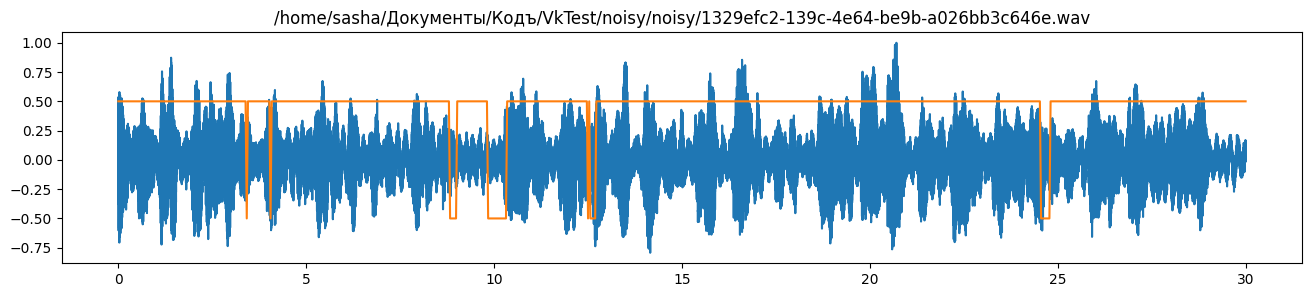


WebRTCVAD


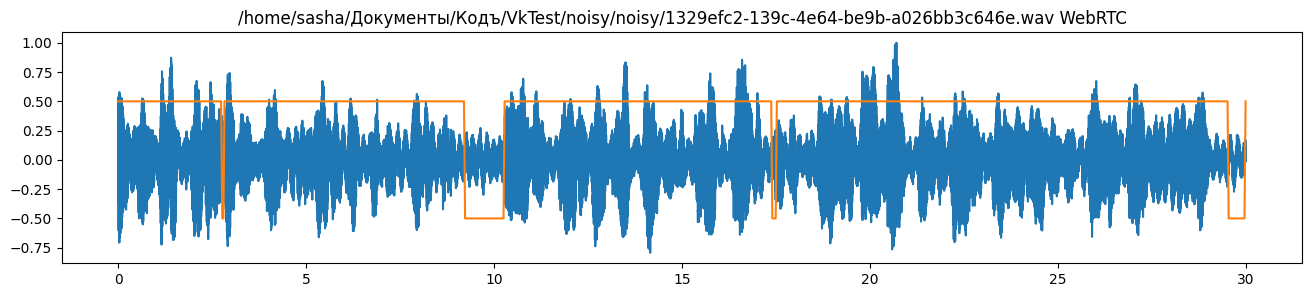

578ce50e-9d76-4d4b-aeb2-c019c5d3cf95.wav

effnet:


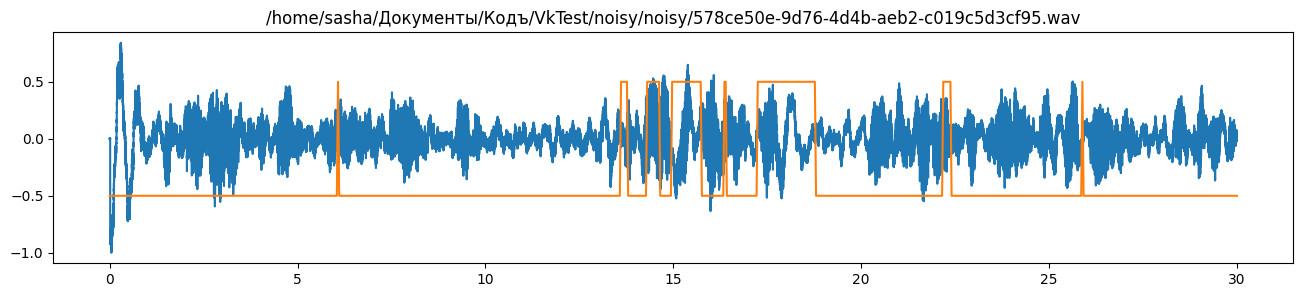


WebRTCVAD


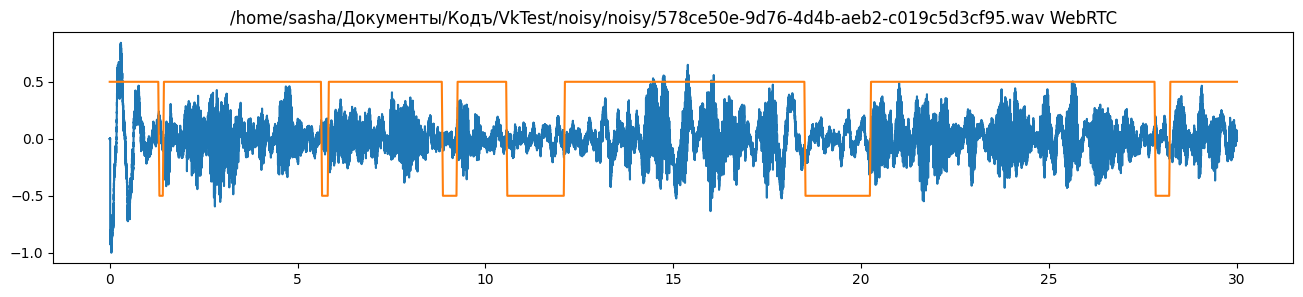

00be0e8a-5629-42c6-84a7-4c1445f83ed2.wav

effnet:


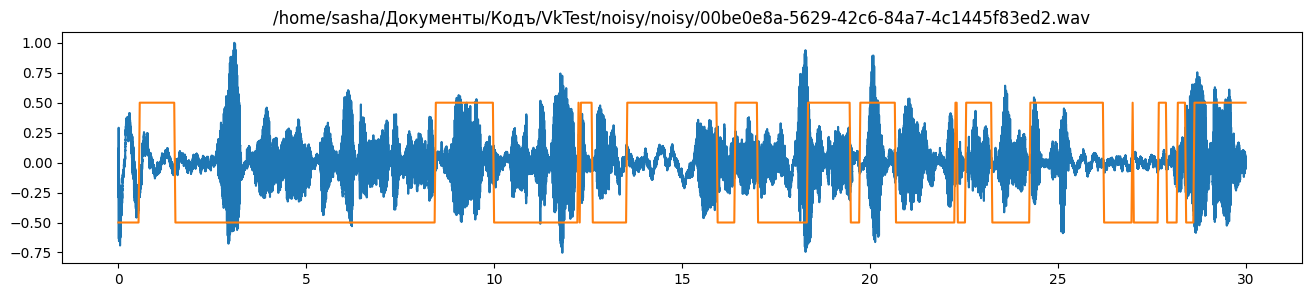


WebRTCVAD


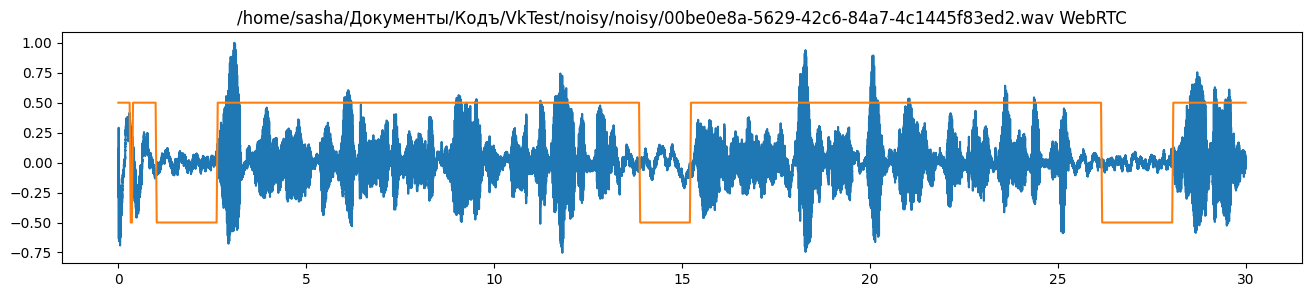

f0012894-ef5b-4fc9-b4de-ddbdb675f129.wav

effnet:


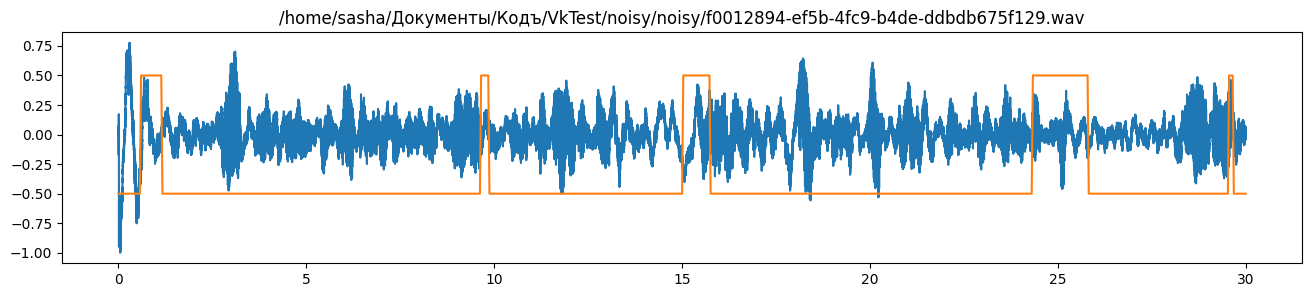


WebRTCVAD


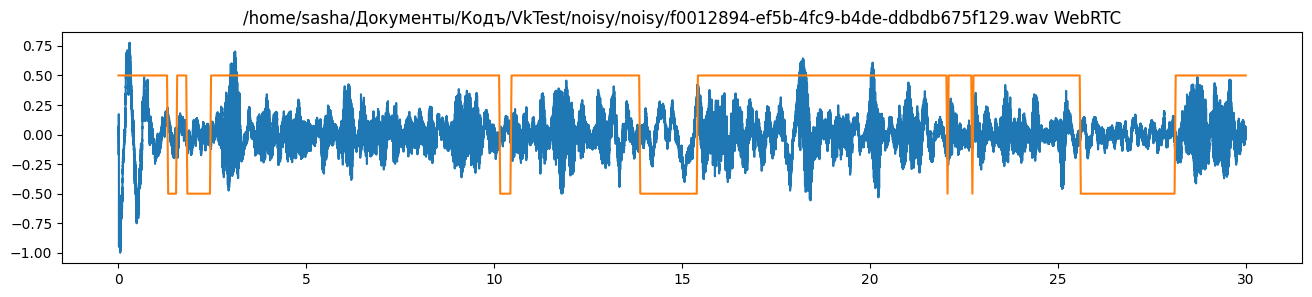

d8ce5865-ff8c-450d-8063-a1d4dfacb969.wav

effnet:


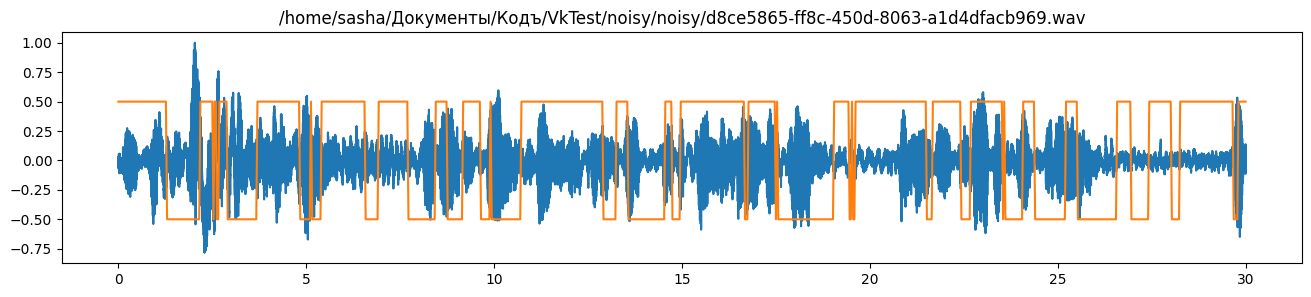


WebRTCVAD


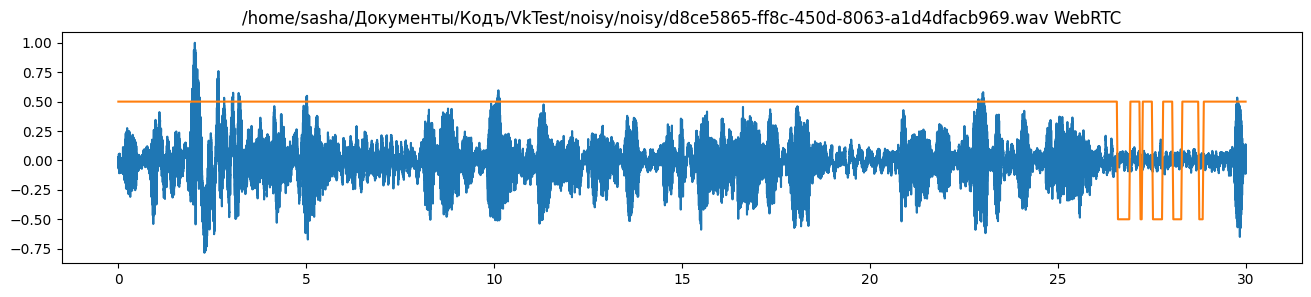

fbe1732f-791e-4dc9-afed-b31b2ed15829.wav

effnet:


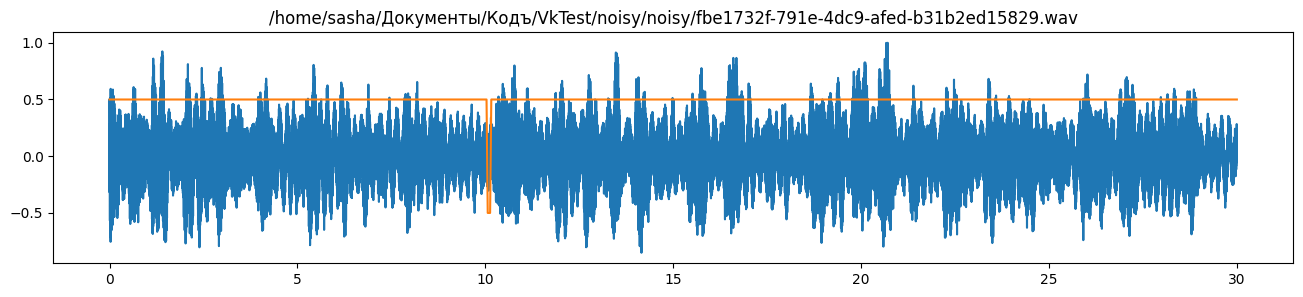


WebRTCVAD


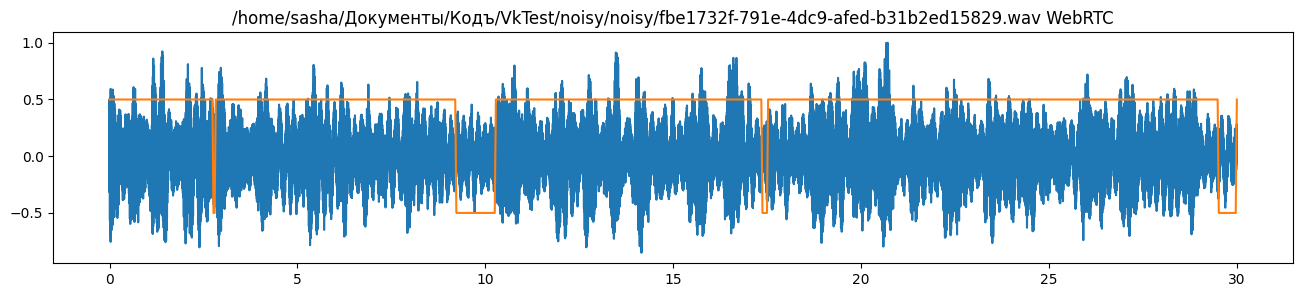

5bafe1e4-67ce-46fe-af90-2d700b0e31b1.wav

effnet:


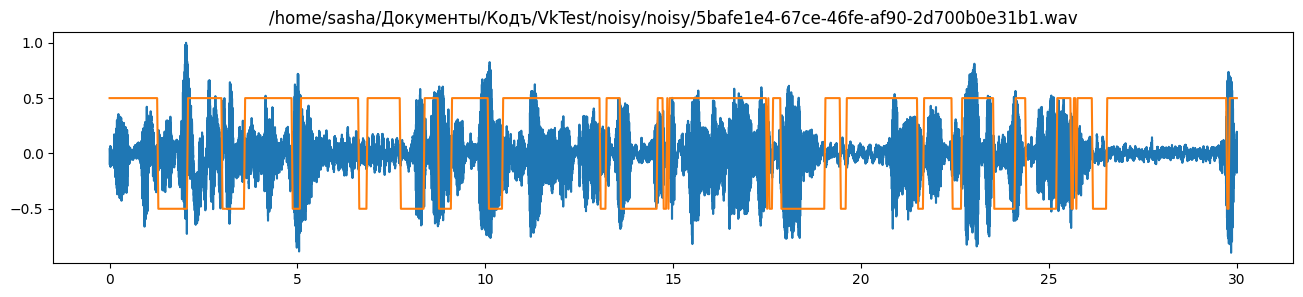


WebRTCVAD


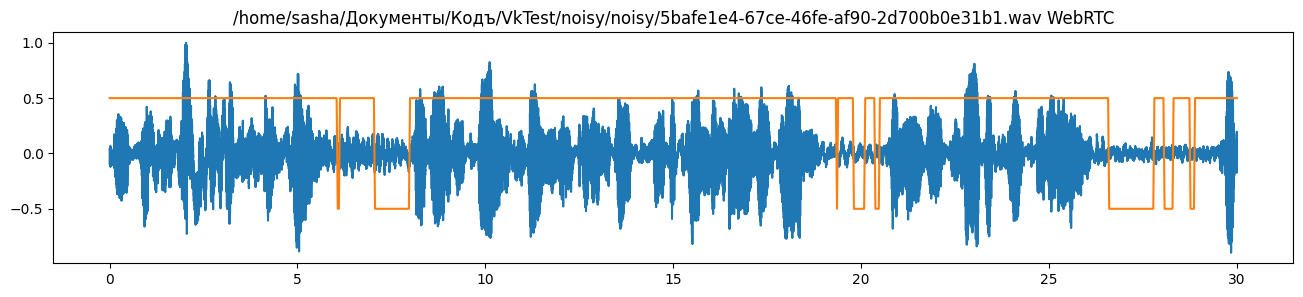

635518e9-704b-4c20-a3a9-6badd653dd4c.wav

effnet:


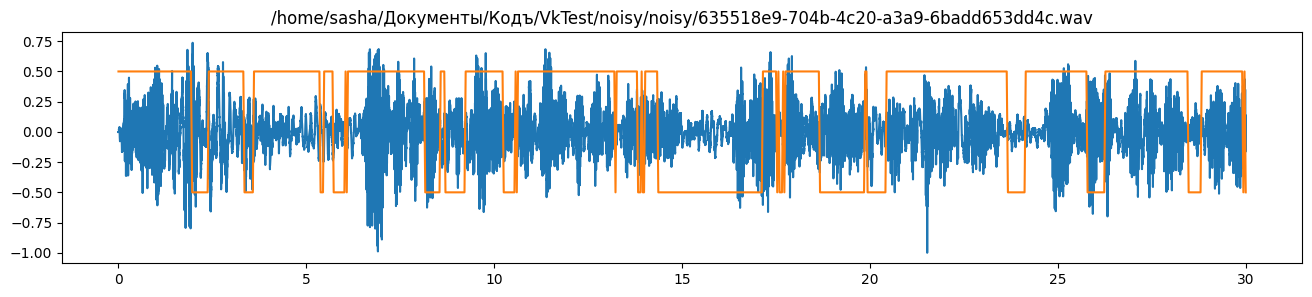


WebRTCVAD


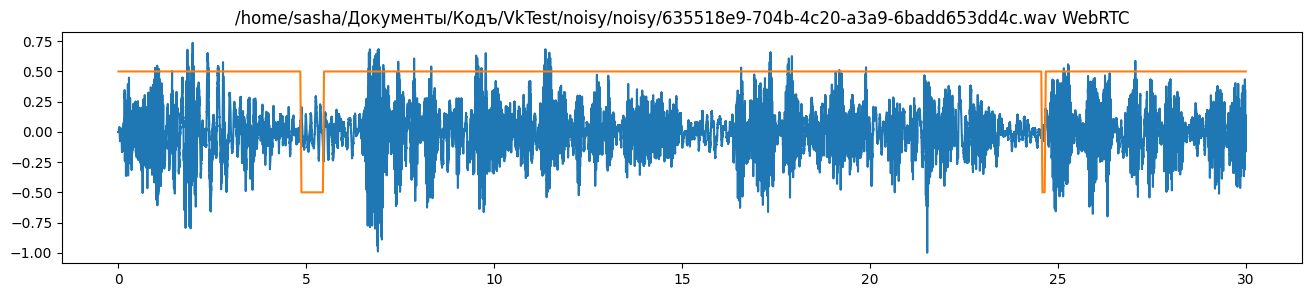

c141feb3-cd72-49bd-80c6-bba0e0f99182.wav

effnet:


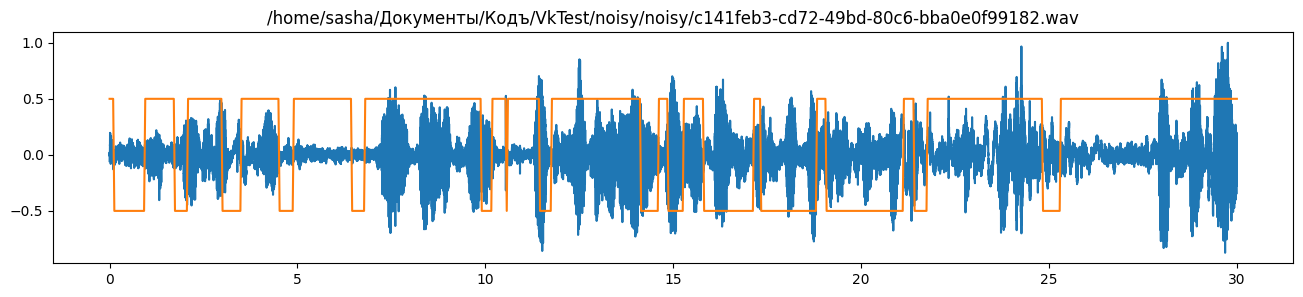


WebRTCVAD


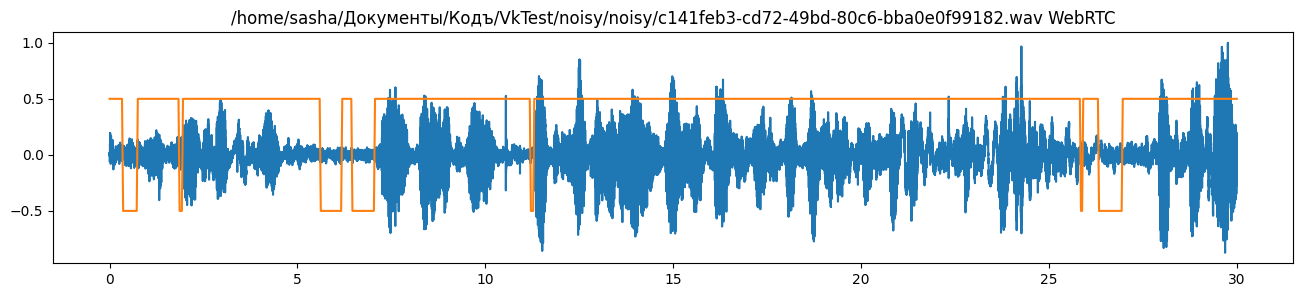

4482412e-f1dd-494d-bea5-869938bcd476.wav

effnet:


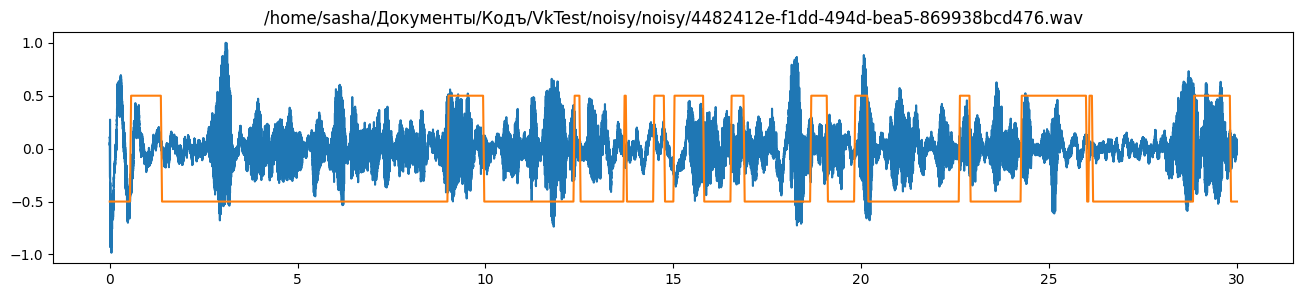


WebRTCVAD


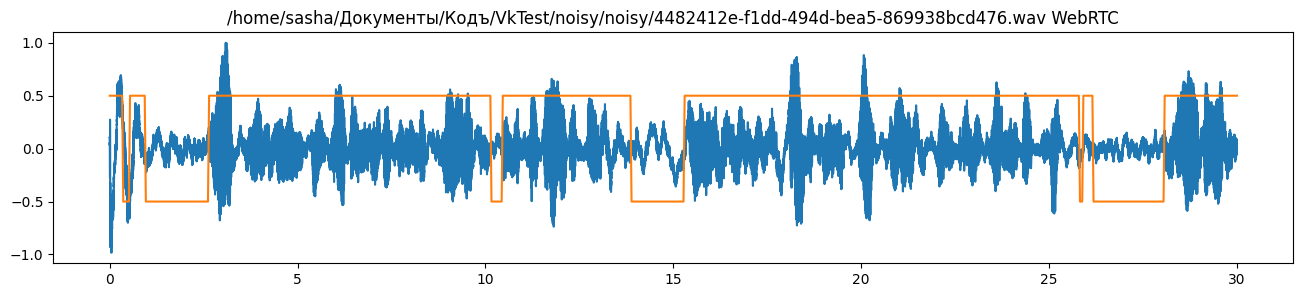

7f3fc54a-1405-4b46-9718-73aa9258b57e.wav

effnet:


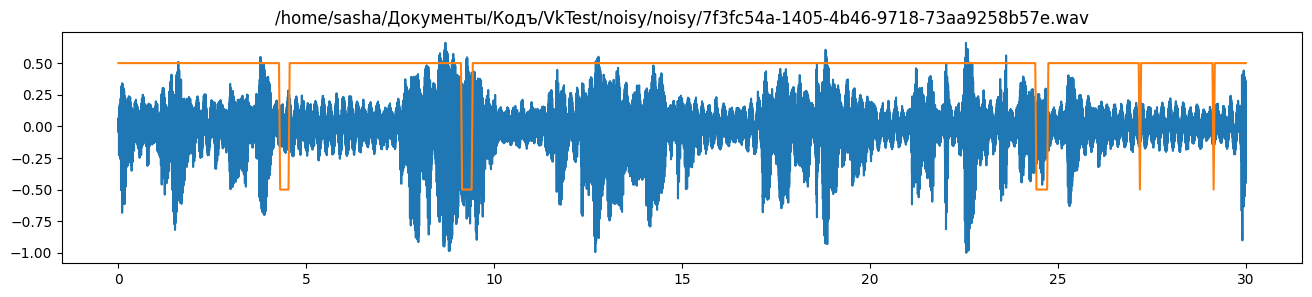


WebRTCVAD


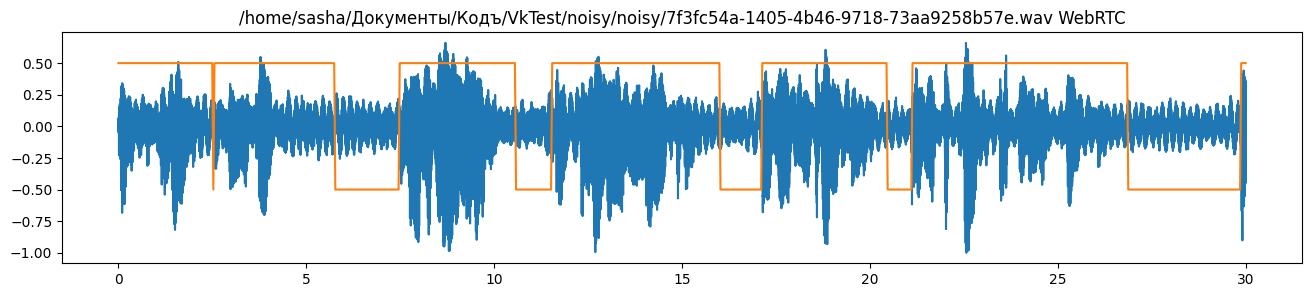

754d1d86-1554-4852-ab6e-eae28fafb736.wav

effnet:


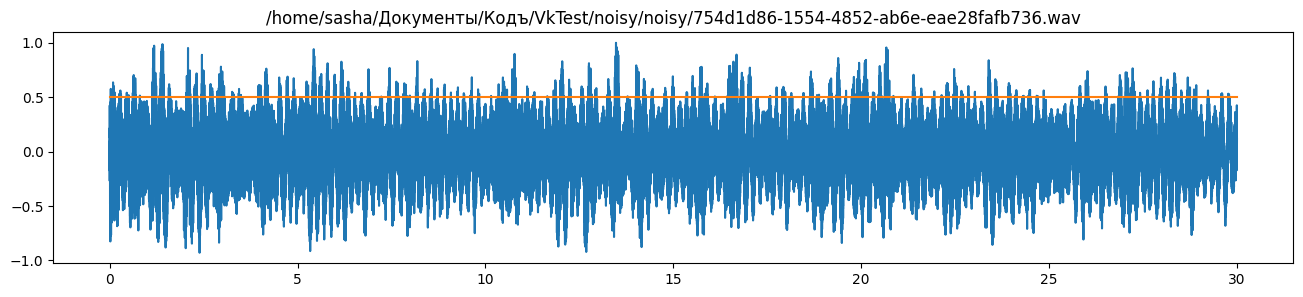


WebRTCVAD


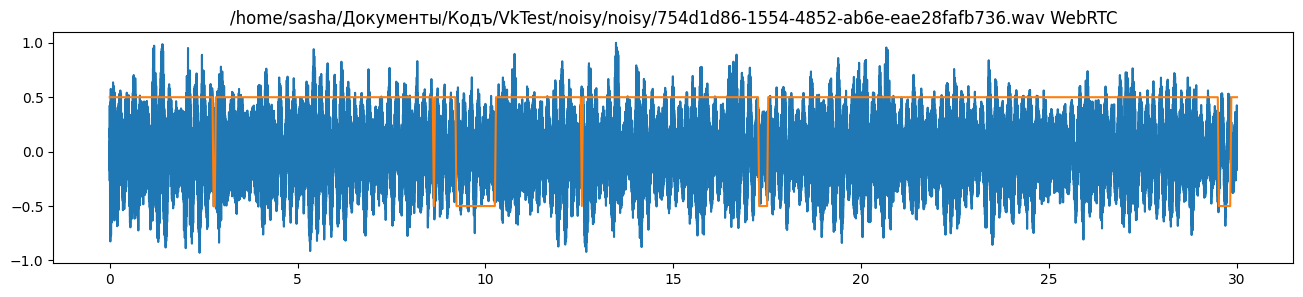

5c50598a-8b1d-4726-805b-9314369f5e14.wav

effnet:


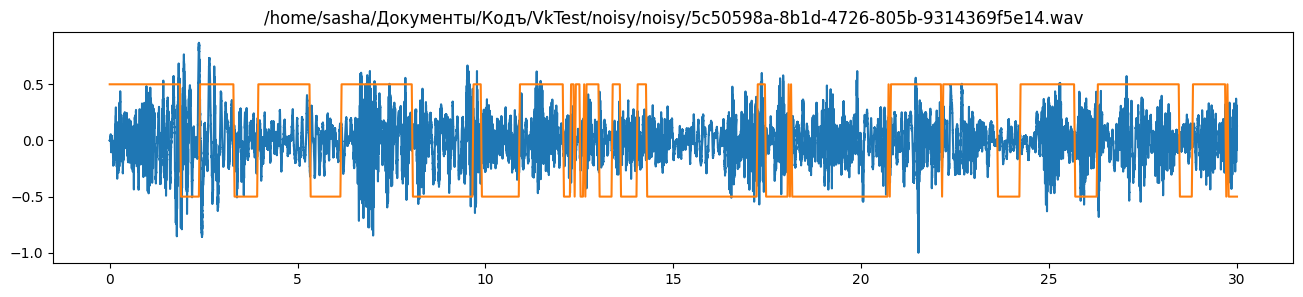


WebRTCVAD


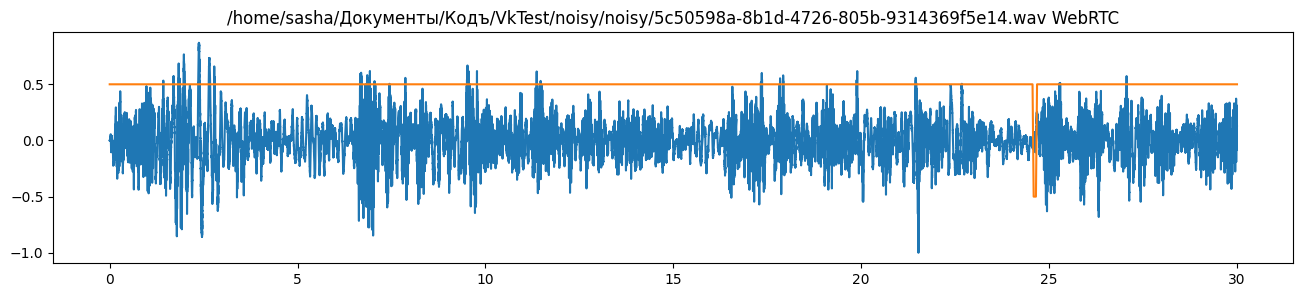

d60aa623-fcf5-4e7f-86fa-83d28006925a.wav

effnet:


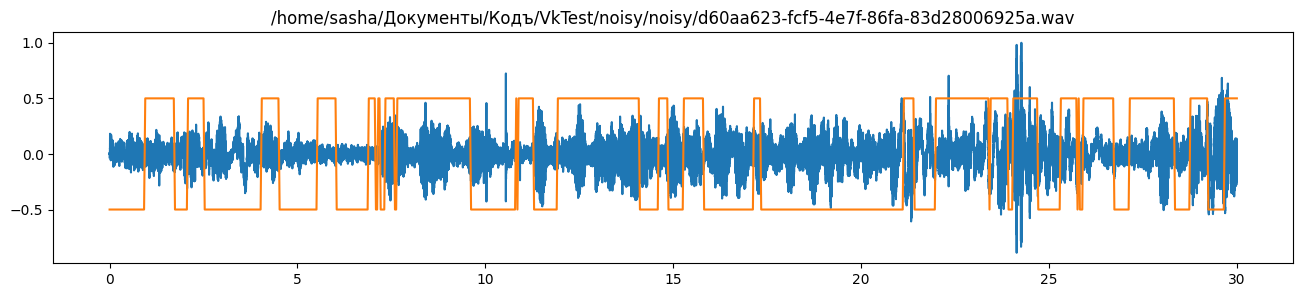


WebRTCVAD


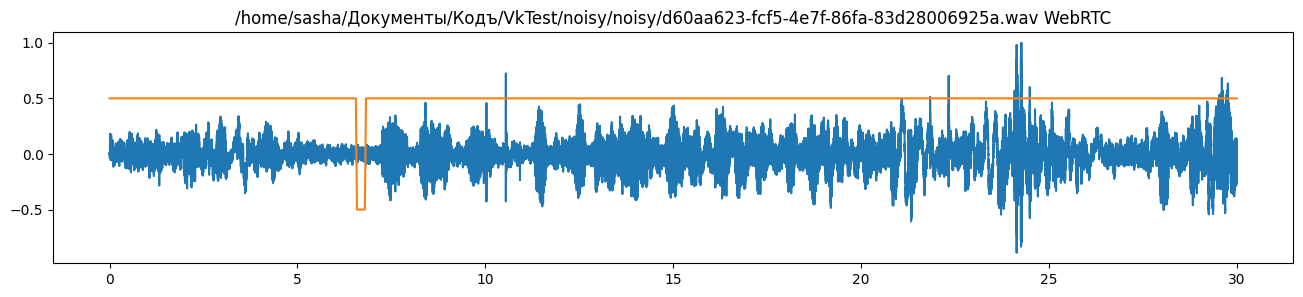

beffddb9-24a7-4339-87f8-b82150119c29.wav

effnet:


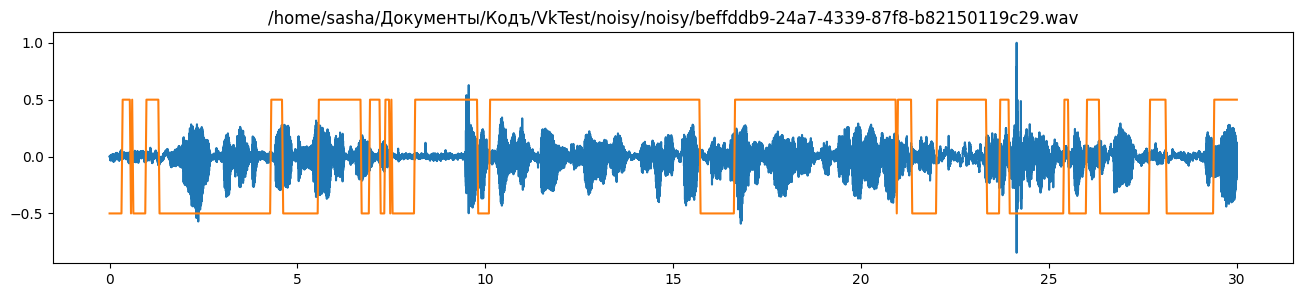


WebRTCVAD


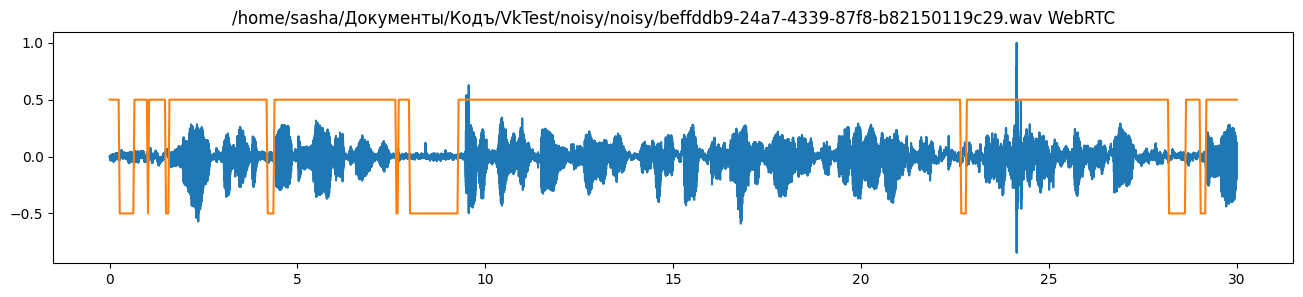

4d6a1bfc-6288-481a-8bc7-90a647fa8bdc.wav

effnet:


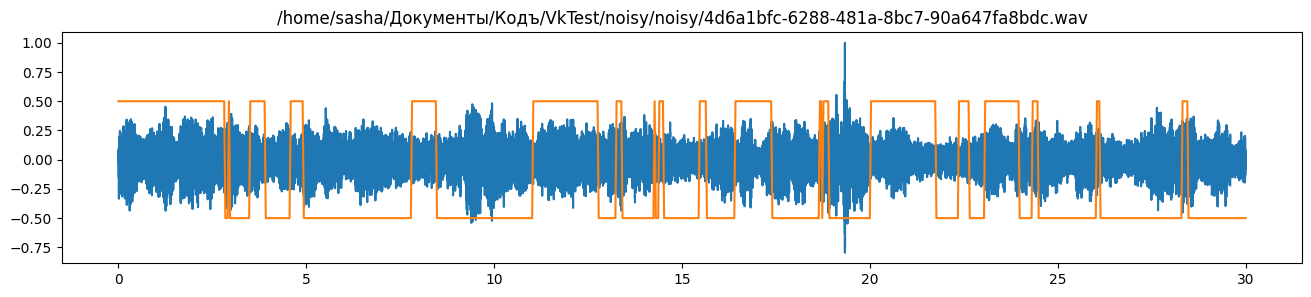


WebRTCVAD


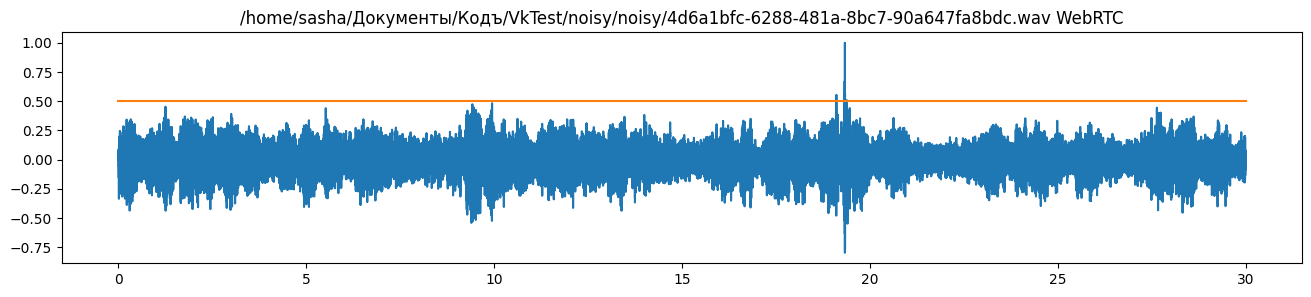

11303826-cffd-4ff5-94ba-1e3b03ab17a0.wav

effnet:


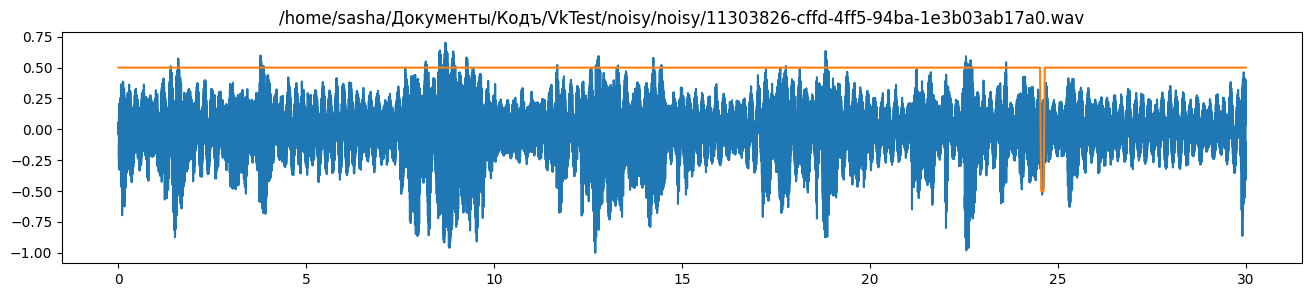


WebRTCVAD


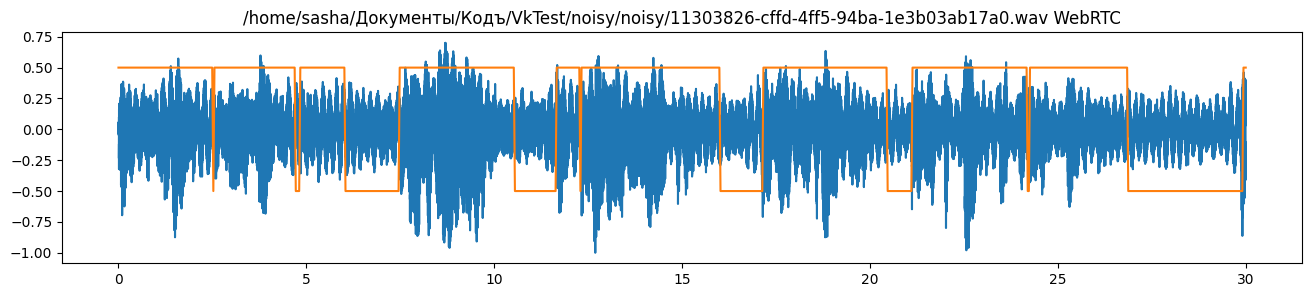

b22e8ea2-f158-4530-a3fc-566b8e890023.wav

effnet:


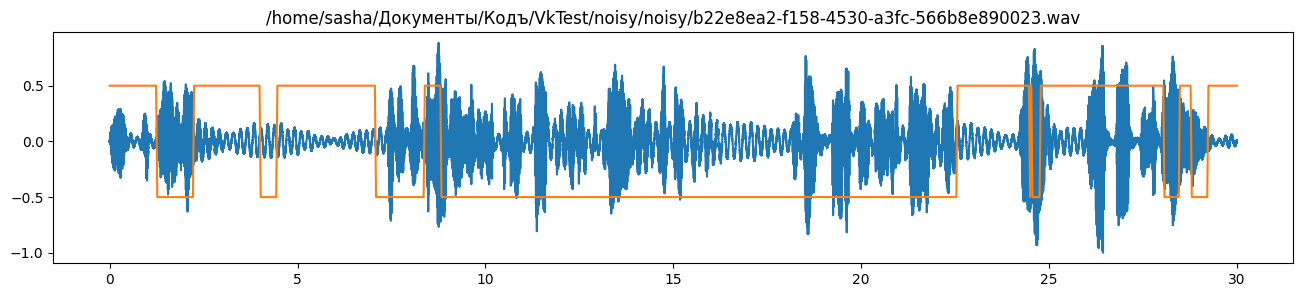


WebRTCVAD


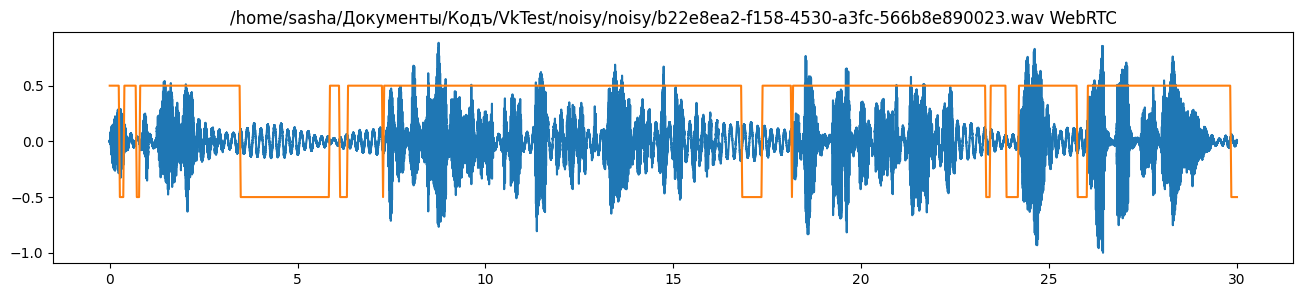

6a0c70ba-cf2b-4407-8155-7c047b8fc727.wav

effnet:


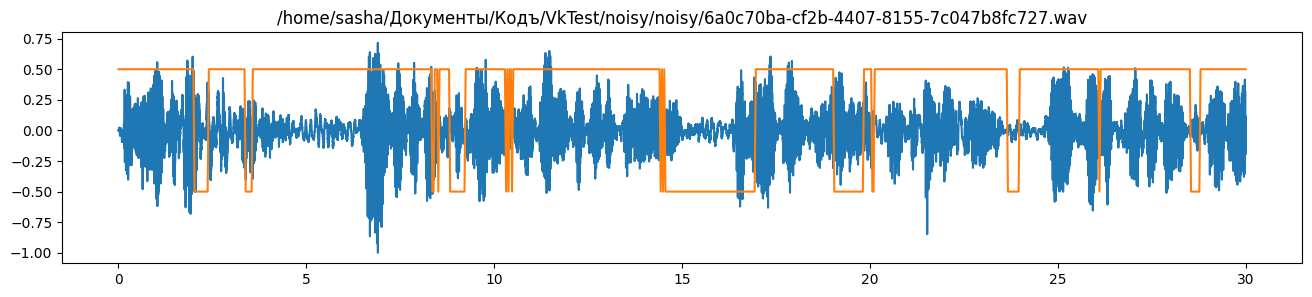


WebRTCVAD


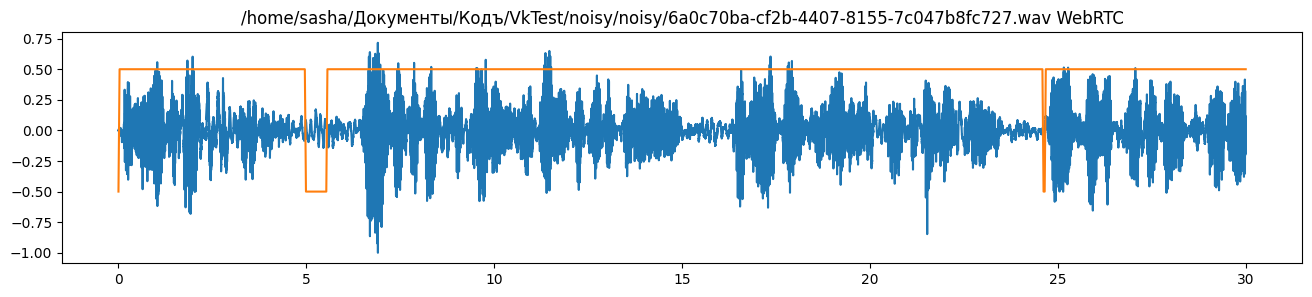

e549134c-cd71-4a8d-80df-8037c540922e.wav

effnet:


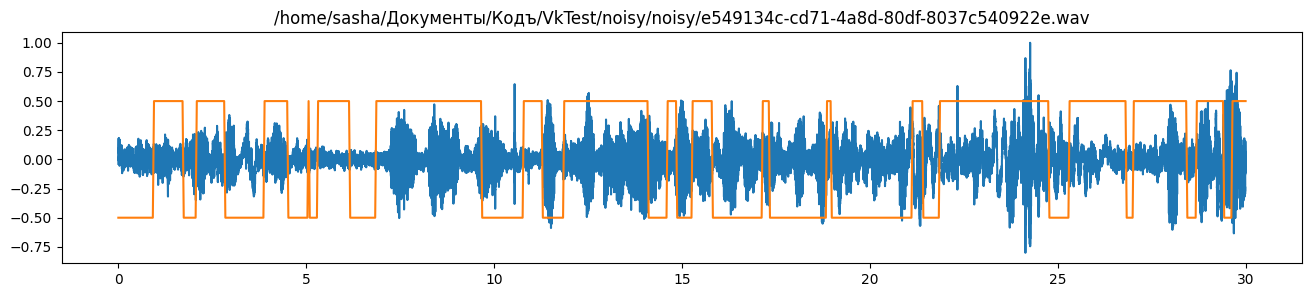


WebRTCVAD


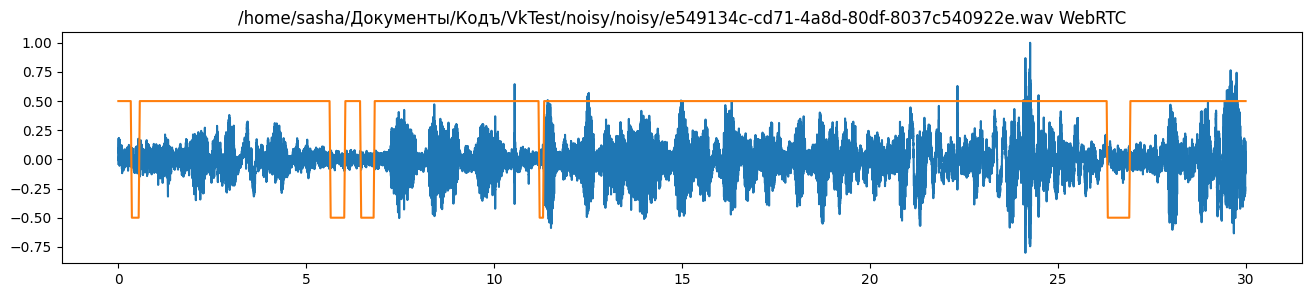

cac1dc0e-fded-434c-ba8f-f41a02ef3417.wav

effnet:


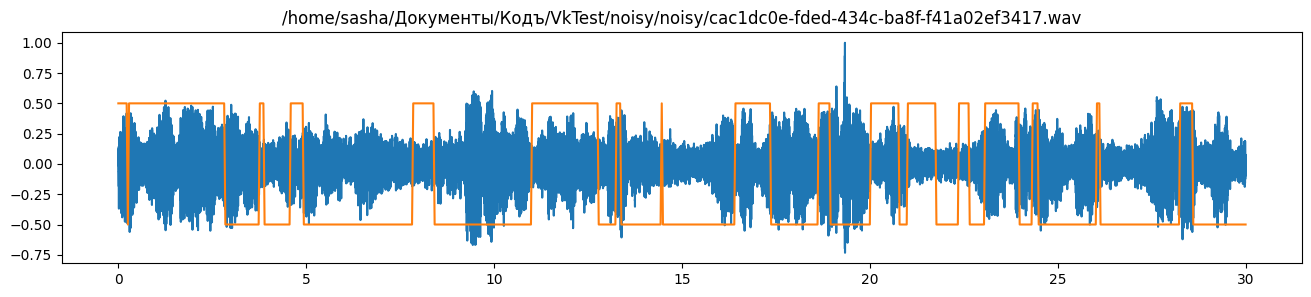


WebRTCVAD


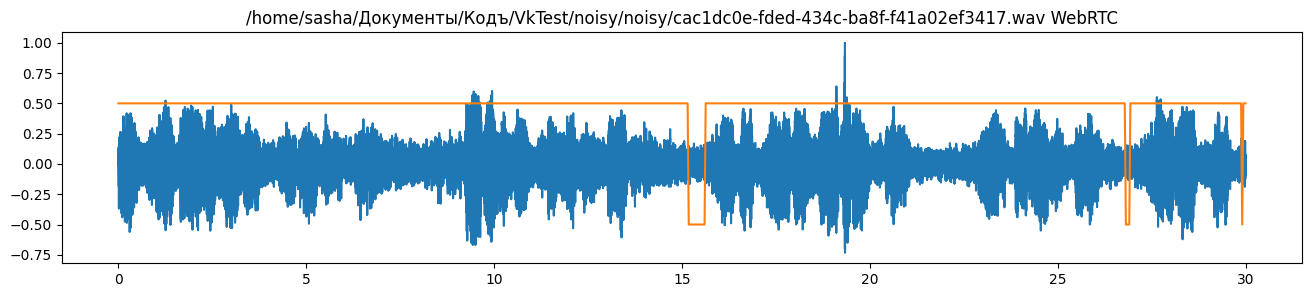

2ade3ddb-59d2-44d5-9325-6019ae9792dc.wav

effnet:


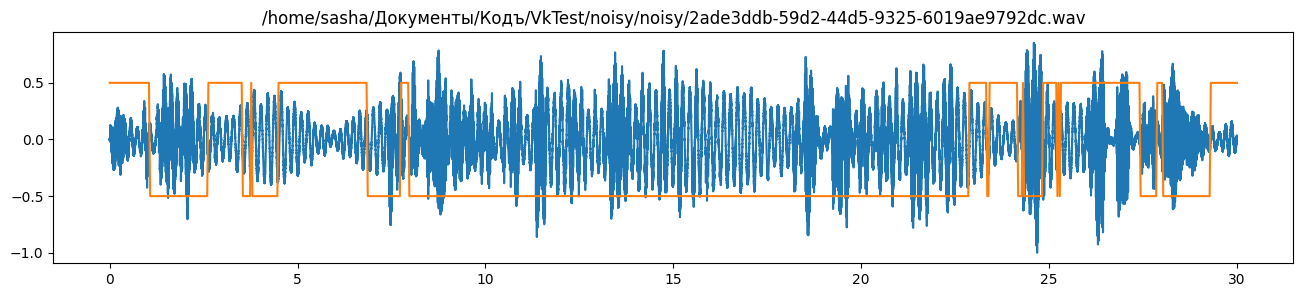


WebRTCVAD


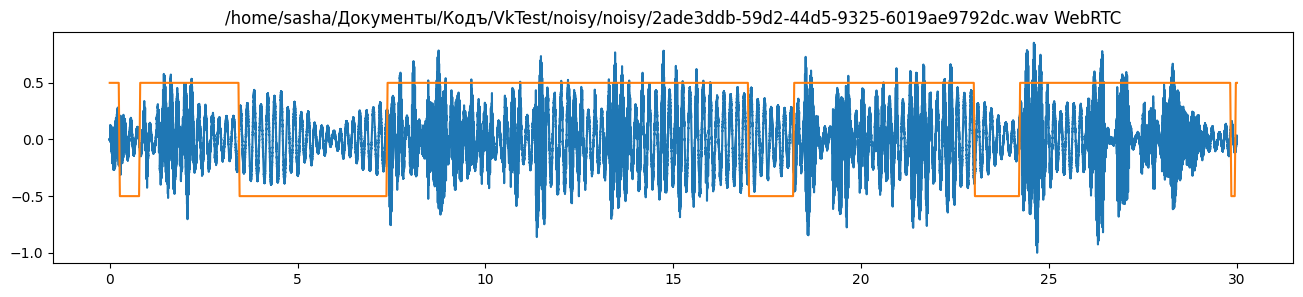

5160a665-dc65-430a-a55c-7450cc225fc9.wav

effnet:


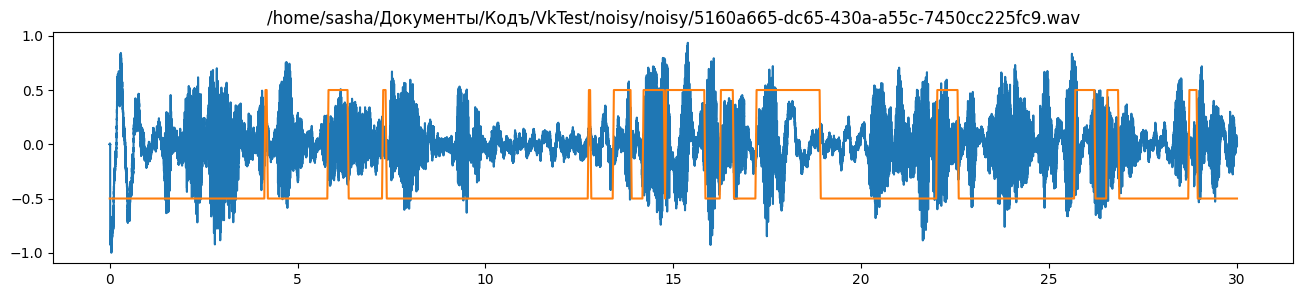


WebRTCVAD


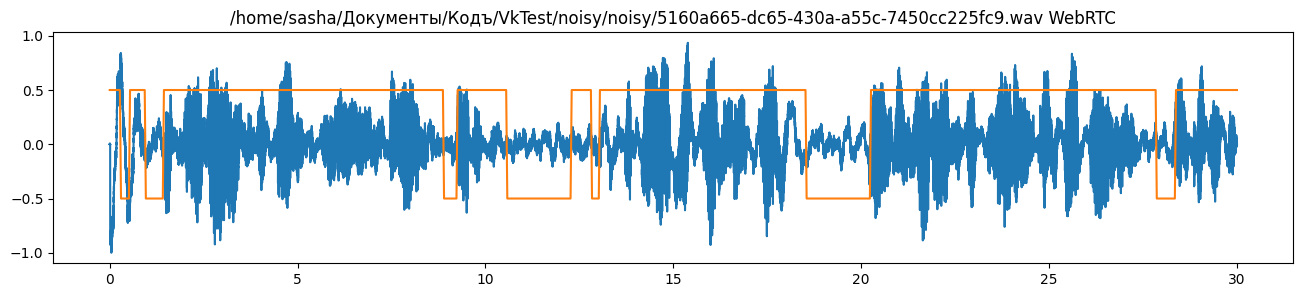

bb212213-32a2-4fbd-81ef-78a7d492f452.wav

effnet:


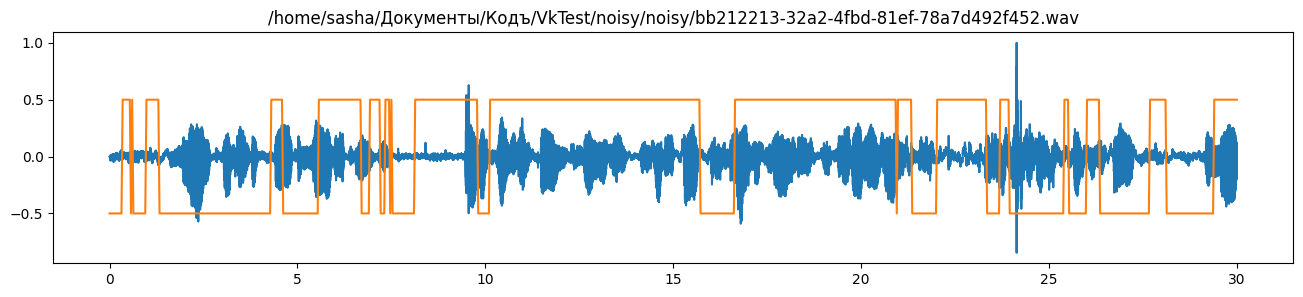


WebRTCVAD


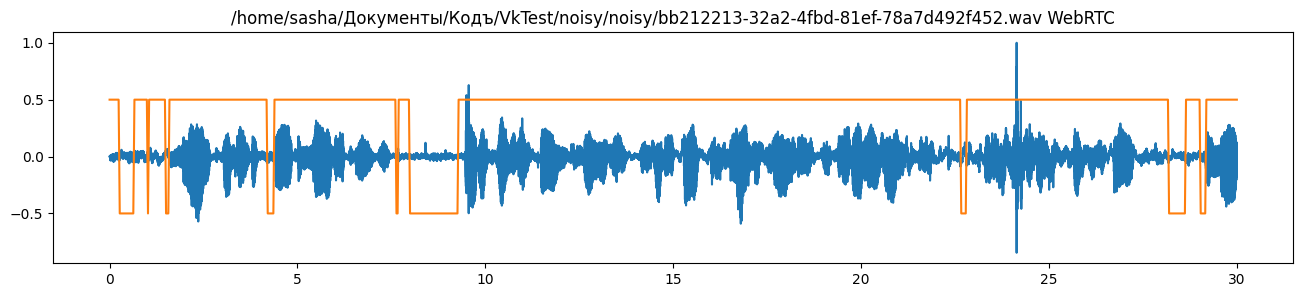

cefa1d2b-7262-4bdb-b22a-6606566a902e.wav

effnet:


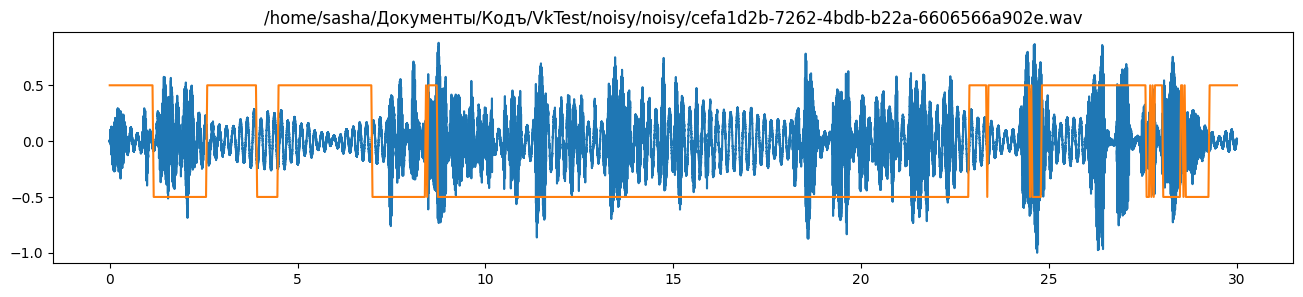


WebRTCVAD


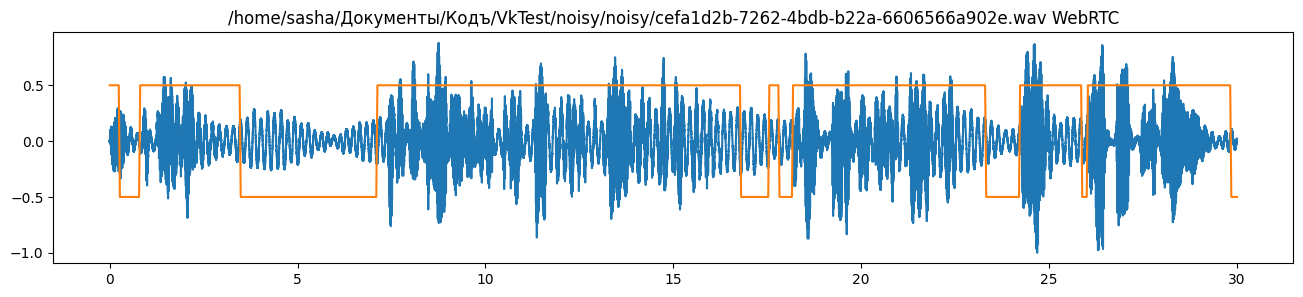

19e8c8ff-24a0-4d98-9f4e-4b8020bdd1da.wav

effnet:


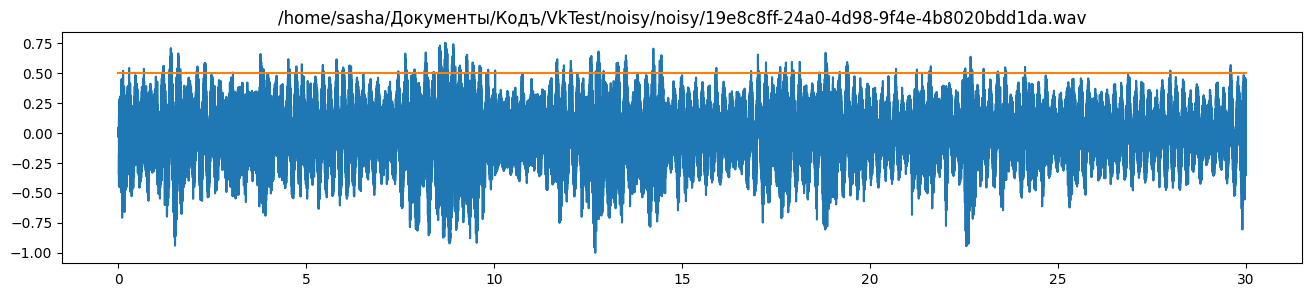


WebRTCVAD


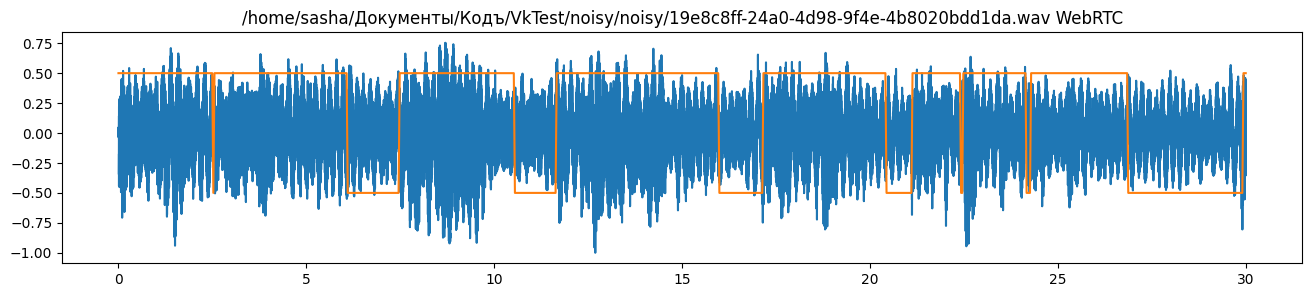

6a55c513-e4e6-4fc9-a904-a5a0af1f0754.wav

effnet:


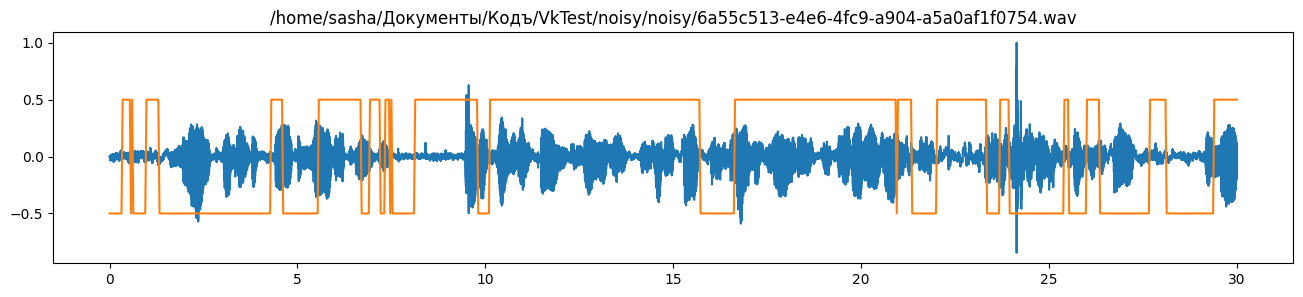


WebRTCVAD


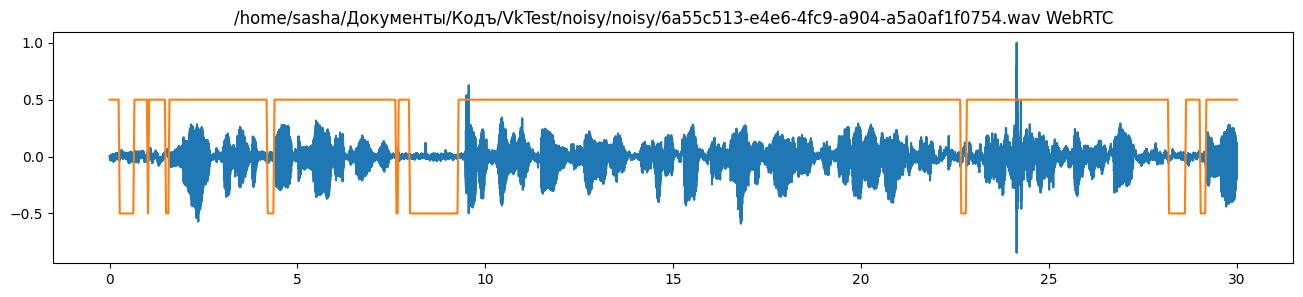

fbe7125a-a61b-425a-b045-783d700d890a.wav

effnet:


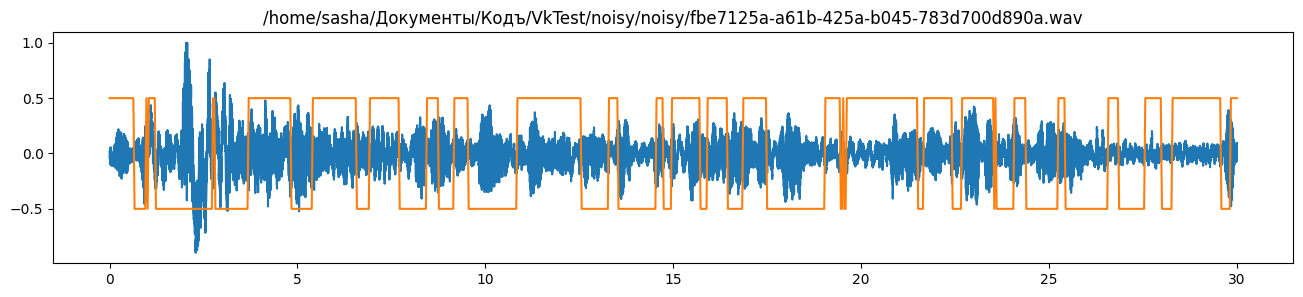


WebRTCVAD


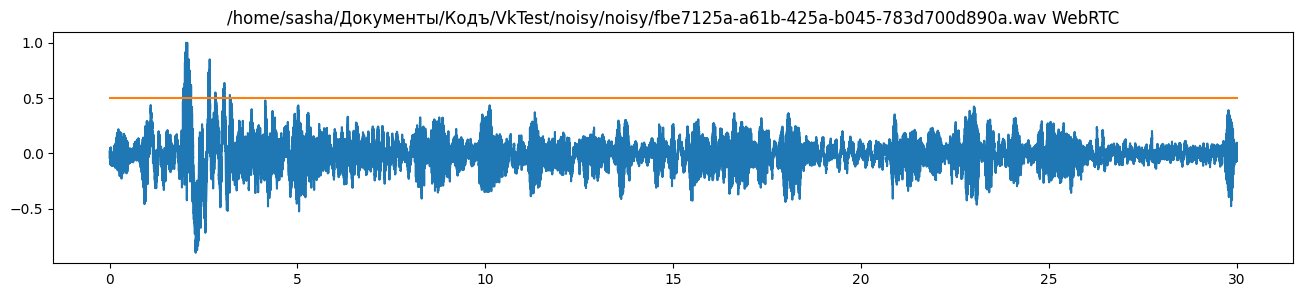

220cd36c-2106-41e4-a1a5-9b5bbe5880c0.wav

effnet:


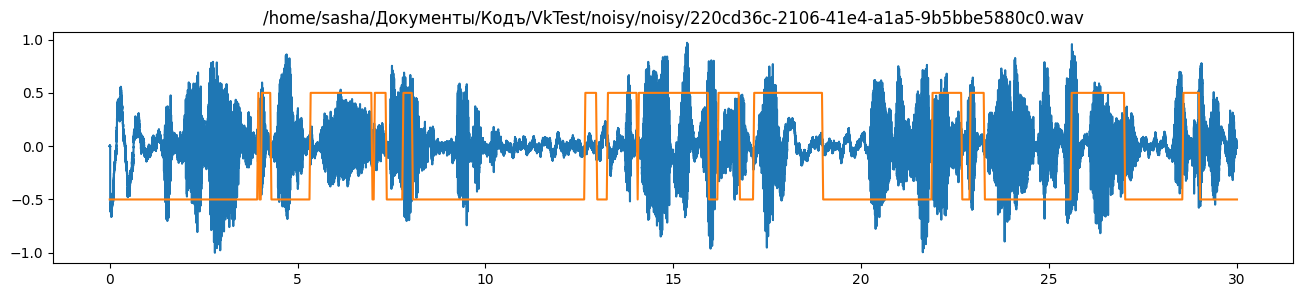


WebRTCVAD


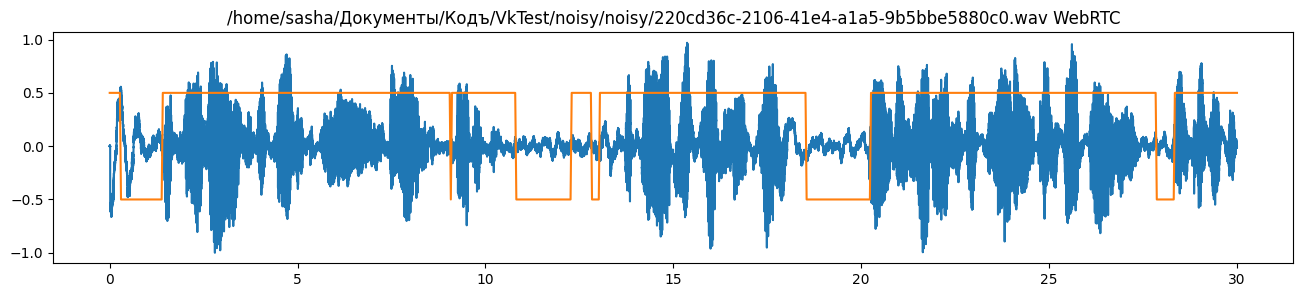

4042f726-2159-4554-84d1-33d532704d82.wav

effnet:


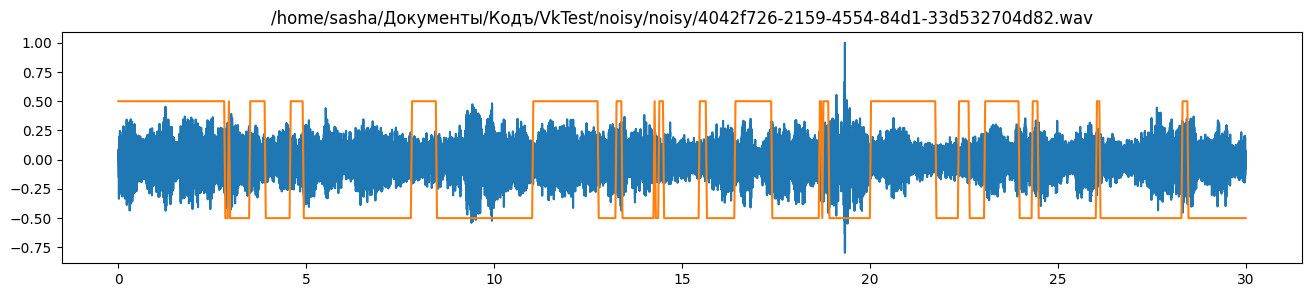


WebRTCVAD


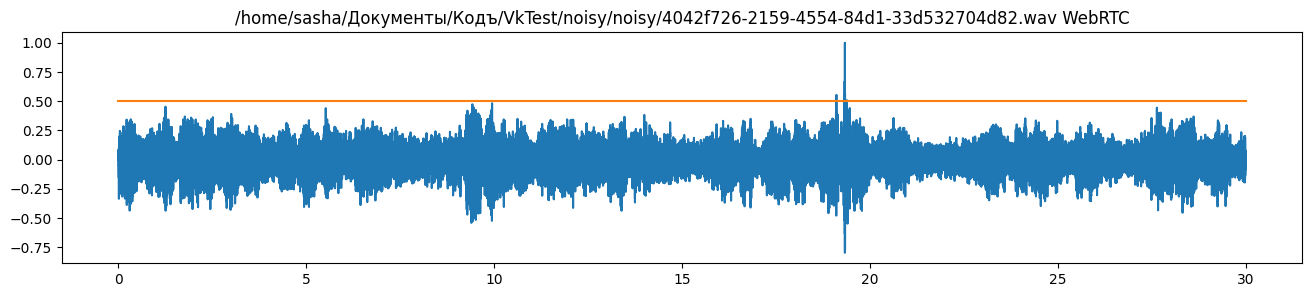

In [26]:
print('\nTest set evaluation:')

test_root = r'/home/sasha/Документы/Кодъ/VkTest/noisy/noisy'

for file in os.listdir(test_root):
    print(file)

    print('\neffnet:')
    to_file = vad(effnet, os.path.join(test_root, file))
    with open(os.path.join(r'/home/sasha/Документы/Кодъ/VkTest', test_root.split('\\')[-1]+'.txt'), 'a') as res_file:
        res_file.write(str(to_file))
        res_file.write("\n")
    
    print('\nWebRTCVAD')
    
    to_rtc_file = vad_webrtc(os.path.join(test_root, file))
    with open(os.path.join(r'/home/sasha/Документы/Кодъ/VkTest', test_root.split('\\')[-1]+'_webrtc.txt'), 'a') as res_web_file:
        res_web_file.write(str(to_rtc_file))
        res_web_file.write("\n")

In [ ]:
import os

# Путь к исполняемому файлу rnnoise_demo
RNNOISE_EXECUTABLE = "/home/sasha/rnnoise/examples/rnnoise_demo"

# Папка с тестовыми аудиофайлами
TEST_FOLDER = "./test_files"

# Папка для сохранения обработанных аудиофайлов
OUTPUT_FOLDER = "./output_files"

# Создаем папку для сохранения обработанных файлов, если она еще не существует
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Проходим по всем файлам в папке с тестовыми данными
for filename in os.listdir(TEST_FOLDER):
    if filename.endswith(".wav"):
        input_file = os.path.join(TEST_FOLDER, filename)
        output_file = os.path.join(OUTPUT_FOLDER, filename)

        # Запускаем rnnoise_demo для обработки текущего аудиофайла
        command = f"{RNNOISE_EXECUTABLE} {input_file} {output_file}"
        os.system(command)

print("Обработка завершена.")
